In [2]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,Dense,Dropout,Bidirectional,LSTM,InputLayer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import re
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords


Using TensorFlow backend.


In [2]:
"""
Fetching the dataset from the dataset folder

"""

import os 
os.listdir("./dataset")
dataset = bz2.BZ2File('./dataset/train.ft.txt.bz2')
test_data = bz2.BZ2File('./dataset/test.ft.txt.bz2')

In [ ]:
def getData(dataset):
    """
    Split the data From the labels
    
    Input : dataset
    
    return value : array of labels, array of text reviews
    
    """
    labels = []
    texts = []
    for line in dataset:
        sentence = line.decode("utf-8")
        label,text = sentence.split(" ",1)
        labels.append(label)
        texts.append(text)
    return np.array(labels),texts
train_labels,train_texts = getData(dataset)
test_labels,test_texts = getData(test_data)

In [ ]:
"""
Building a DataFrame
"""
labels = pd.Series(train_labels)
texts = pd.Series(train_texts)
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
df = pd.DataFrame()
df['labels'] = labels
df['texts'] = texts

labels = pd.Series(test_labels)
texts = pd.Series(test_texts)
labels = encoder.fit_transform(labels)
df_test = pd.DataFrame()
df_test['labels'] = labels
df_test['texts'] = texts

train_data = df[:20000]
test_data = df[:5000]

# Labels Distribution

In [ ]:
"""
Count values for each labels

"""
print("labels in the dataset : ",train_data.labels.unique())
print(f"\ntrain data distribution\n{train_data.labels.value_counts()}")
print(f"\ntest data distribution\n{test_data.labels.value_counts()}")

In [ ]:
def preprocessing(data):
    """
    Preprocessing the data by removing the stopwords, non ascii, punctuation and digits
    
    input : data
    return value : processed data
    
    """
    preprocessed = []
    
    for sents in data:
        
        #text1 = sents.lower()
        tokens = nltk.word_tokenize(sents)
        """
            Removing Stopword
        """
        text1 = " ".join(w.lower()  for w in tokens if not w in stopwords.words())
        """
        Removing Punctuations
        """
        text1 = re.compile(r'[\W]').sub(r' ',text1) 
        """
        Removing Non Ascii words
        """
        text1 = re.compile(r'[^a-z0-1\s]').sub(r' ',text1)
        """
        Removing Digits
        """
        text1 = re.sub("(\s\d+)","",text1)
        preprocessed.append(text1)
        
    return preprocessed

In [ ]:
cleaned_train = preprocessing(train_data.texts)
cleaned_test = preprocessing(test_data.texts)
cleaned_data = pd.DataFrame()
cleaned_data['labels'] = train_data.labels
cleaned_data['texts'] = cleaned_train

cleaned_test = pd.DataFrame()
cleaned_test['labels'] = test_data.labels
cleaned_test['texts'] = cleaned_test

cleaned_data.to_csv("ptrain_data.csv",index=None)
cleaned_test.to_csv("ptest_data.csv",index=None)


In [3]:
train = pd.read_csv("ptrain_data.csv")
test = pd.read_csv("ptest_data.csv")

In [4]:

"""
Tokenizing the sentences

"""
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.texts)
train_texts = tokenizer.texts_to_sequences(train.texts)
test_texts = tokenizer.texts_to_sequences(test.texts)

In [5]:
MAX_FEATURES = len(tokenizer.word_index)+1

In [6]:
"""
Padding the sentences to maxlength

"""

MAX_LENGTH = max(len(train_ex) for train_ex in train_texts)
train_text = pad_sequences(train_texts, maxlen=MAX_LENGTH)
test_text = pad_sequences(test_texts, maxlen=MAX_LENGTH)

In [7]:
"""
Building a BiLSTM model 
Embedding layer -> embed dim = 64
Dropout -> 0.5
BiLSTM Layer :units -> 128
Dense layer : 64 units, relu activation
output dense layer 1 unit, sigmoid activation

"""
model = Sequential()
model.add(Embedding(MAX_FEATURES,64,input_length=MAX_LENGTH))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 204, 64)           3039296   
_________________________________________________________________
dropout_1 (Dropout)          (None, 204, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,253,441
Trainable params: 3,253,441
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
"""
Fitting the model on the dataset with validation of 0.2 and 5 epochs
"""
num_epochs = 5
history = model.fit(train_text, train.labels, epochs=num_epochs,validation_split=0.25)


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 [==============================] - 112s 7ms/step - loss: 0.5232 - accuracy: 0.7261 - val_loss: 0.3876 - val_accuracy: 0.8304
Epoch 2/5
15000/15000 [==============================] - 111s 7ms/step - loss: 0.2555 - accuracy: 0.8991 - val_loss: 0.3518 - val_accuracy: 0.8522
Epoch 3/5
15000/15000 [==============================] - 116s 8ms/step - loss: 0.1505 - accuracy: 0.9457 - val_loss: 0.4187 - val_accuracy: 0.8516
Epoch 4/5
15000/15000 [==============================] - 116s 8ms/step - loss: 0.1014 - accuracy: 0.9639 - val_loss: 0.4981 - val_accuracy: 0.8466
Epoch 5/5
15000/15000 [==============================] - 114s 8ms/step - loss: 0.0783 - accuracy: 0.9717 - val_loss: 0.4747 - val_accuracy: 0.8374


In [71]:
predictions = model.predict(test_text)


In [54]:
"""
Generating Results for our predictions
"""

Accuracy_score = accuracy_score(test.labels,(predictions > 0.5) * 1)
Confusion_matrix = confusion_matrix(test.labels,(predictions > 0.5) * 1)
Classification_report = classification_report(test.labels,(predictions > 0.5) * 1)

# ACCURACY

In [55]:
print("Accuracy score for the test data :",Accuracy_score)

Accuracy score for the test data : 0.8008


# Confusion Matrix

In [14]:
print("Confusion Matrix :\n",Confusion_matrix)

Confusion Matrix :
 [[1812  562]
 [ 434 2192]]


# Classification Report

In [15]:
print("Classification Report\n",Classification_report)

Classification Report
               precision    recall  f1-score   support

           0       0.81      0.76      0.78      2374
           1       0.80      0.83      0.81      2626

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



In [39]:
"""
Generating the graphs

"""

from matplotlib import pyplot as plt
x1 = model.history.history['accuracy']
x2 = model.history.history['val_accuracy']

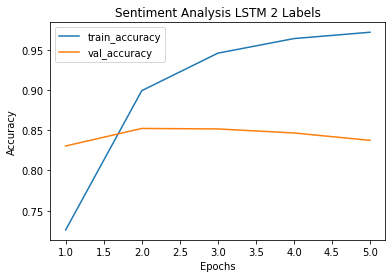

In [57]:
plt.plot([1,2,3,4,5],x1,label="train_accuracy")
plt.plot([1,2,3,4,5],x2,label = "val_accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("Sentiment Analysis LSTM 2 Labels")
plt.legend()
plt.show()

In [ ]:
model.save("lstm5model.h5")


In [2]:
from tensorflow import keras
models = keras.models.load_model('lstm5model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
"""
Manually checking the output

"""
input_sentence = ["This product is so nice and it is so cheap "]

test_check = tokenizer.texts_to_sequences(input_sentence)
test_final = pad_sequences(test_check, maxlen=MAX_LENGTH)
#print(test_final)
if (models.predict(test_final) > 0.5) * 1 == 1:
    print("1")
else:
    print("0")